In [37]:
import numpy as np
import matplotlib.pyplot as plt

def lambert_beer_law(concentration_A,concentration_B, path_length, extinction_coefficient_A,extinction_coefficient_B, resolution):
    """
    Calculate the absorbance and transmittence using Lambert-Beer law, and plots them against path length.

    Parameters
    ----------
    concentration : float or ndarray
        Concentration of the absorbing species (e.g., O2) in mol/m^3.
    path_length : float
        Path length through which the light passes in meters.
    extinction_coefficient : float
        Extinction coefficient in m^2/mol.

    resolution : int
        Number of steps for the path length.

    Returns
    -------
    absorbance : float or ndarray
        Calculated absorbance.
    transmittance : float or ndarray
    """


    path_length_steps = np.linspace(0, path_length, resolution)
    absorbance = concentration_A * path_length_steps * extinction_coefficient_A+concentration_B * path_length_steps * extinction_coefficient_B
    transmittance = 10**(-absorbance)

    #plt.plot(path_length_steps, transmittance, label='Transmittance')
    #plt.legend()
    return absorbance, transmittance




In [38]:


def Absorption_model(num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx):
    steps = int(path_length / dx)

    # Linear attenuation coefficients
    mu_A = epsilon_A * conc_A
    mu_B = epsilon_B * conc_B
    mu_total = mu_A + mu_B

    # Total absorption probability per step
    prob_abs = 1 - np.exp(-mu_total * dx)

    photons_alive = np.ones(num_photons, dtype=bool)
    distances = np.zeros(num_photons)

    absorption_profile_A = np.zeros(steps)
    absorption_profile_B = np.zeros(steps)

    for step in range(steps):
        rand_nums = np.random.rand(num_photons)

        # Absorption condition
        absorbed = (rand_nums < prob_abs) & photons_alive

        # Store where absorption occurred
        distances[absorbed] = step * dx

        # Use rand_nums of absorbed photons to assign species
        rand_absorbed = rand_nums[absorbed]
        # Normalize within [0, prob_abs]
        scaled = rand_absorbed / prob_abs  # Now in [0, 1]

        # Assign species based on relative contribution
        prob_A_fractional_abs = mu_A / mu_total if mu_total > 0 else 0
        prob_A_fractional_abs = mu_B / mu_total if mu_total > 0 else 0
        absorbed_A_mask = scaled < prob_A_fractional_abs
        absorbed_B_mask = ~absorbed_A_mask

        absorption_profile_A[step] += np.sum(absorbed_A_mask)
        absorption_profile_B[step] += np.sum(absorbed_B_mask)

        # Mark absorbed photons as no longer alive
        photons_alive[absorbed] = False

    distances[photons_alive] = path_length

    transmitted = np.sum(photons_alive)
    transmission = transmitted / num_photons
    absorbance = -np.log10(transmission)

    return absorbance, distances, absorption_profile_A, absorption_profile_B, transmission


In [39]:

def Absorption_model_Number_line(num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx):

  mu_A = epsilon_A * conc_A * dx


  mu_B = epsilon_B * conc_B * dx


  mu_total = mu_A + mu_B

  fraction_mu_A = mu_A / mu_total
  fraction_mu_B = mu_B / mu_total

  transmittance = 10**(-mu_total)
  absorbed_fraction = 1 - transmittance

  abs_prob_A = fraction_mu_A * absorbed_fraction
  abs_prob_B = fraction_mu_B * absorbed_fraction

### Number line definition
### If random_value is between 0 and non_absorption_prob, the photon is not absorbed.
### If random_value is between non_absorption_prob and absorbed_by_A_prob, the photon is absorbed by A.
### If random_value is between absorbed_by_A_prob and 1, the photon is absorbed by B.

  non_absorption_prob = 1 - absorbed_fraction
  absorbed_by_A_prob = non_absorption_prob + abs_prob_A
  absorbed_by_B_prob = absorbed_by_A_prob + abs_prob_B
  print(non_absorption_prob)
  print(absorbed_by_A_prob)
  print(absorbed_by_B_prob)

  step_list=range(int(path_length / dx))

  A_absorbed_count_per_length = []
  B_absorbed_count_per_length = []
  A_absorbed_cumsum=[]
  B_absorbed_cumsum=[]
  photons_alive = np.ones(num_photons, dtype=bool)

  for i in step_list:
    rand_nums = np.random.rand(np.sum(photons_alive))

    ## Unsuccessfully absorbed
    not_absorbed_mask = rand_nums < non_absorption_prob

    ##sucessfully Absorbed by A
    absorbed_by_A_mask = (rand_nums >= non_absorption_prob) & (rand_nums < absorbed_by_A_prob)

    ##Successfully absorbed by B
    absorbed_by_B_mask = (rand_nums >= absorbed_by_A_prob) & (rand_nums < absorbed_by_B_prob)

    A_absorbed_count_per_length.append(np.sum(absorbed_by_A_mask))
    B_absorbed_count_per_length.append(np.sum(absorbed_by_B_mask))

    alive_indices = np.where(photons_alive)[0]
    photons_alive[alive_indices] = not_absorbed_mask

    A_absorbed_cumsum.append(np.sum(A_absorbed_count_per_length))
    B_absorbed_cumsum.append(np.sum(B_absorbed_count_per_length))

#print(A_absorbed_count_per_length)
#print(B_absorbed_count_per_length)


  return A_absorbed_count_per_length, B_absorbed_count_per_length, A_absorbed_cumsum, B_absorbed_cumsum


/tmp/ipython-input-38-4099929253.py:48: RuntimeWarning: divide by zero encountered in log10
  absorbance = -np.log10(transmission)
/tmp/ipython-input-40-3438899892.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, fraction_A*(transmittance_A_ideal)/x, label='Photons absorbed by A per step in ideal case')  #This gave me something weird. issue with the scaling?


0.9462371613657931
0.9798389355121724
1.0


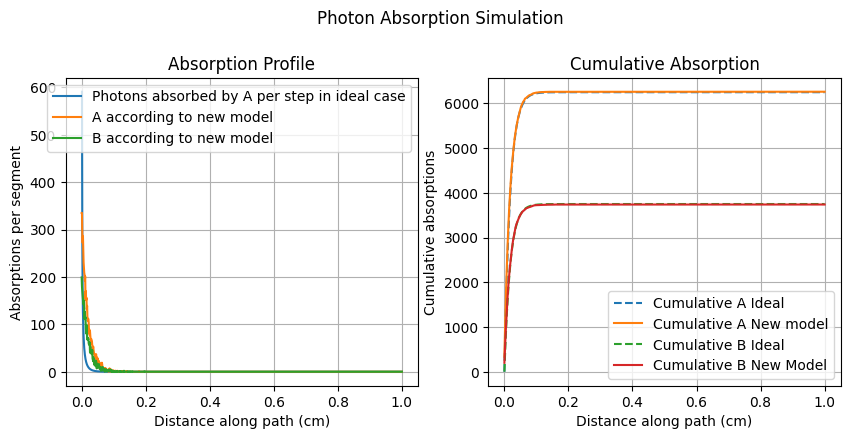

In [40]:
num_photons = 10000            # Number of photons to simulate               # Molar extinction coefficient (L·mol⁻¹·cm⁻¹)
path_length = 1
epsilon_A = 3000.0  # L/(mol*cm)
conc_A = 0.005  # mol/L
epsilon_B = 3000                            ##Situation where A has higher concentration than B
conc_B = 0.003
dx = 0.001
resolution = path_length/dx
resolution = round(resolution) #turns from a float to an int to prevent an error in the linspace function
fraction_A = conc_A*epsilon_A / (conc_A*epsilon_A + conc_B*epsilon_B)
fraction_B = conc_B*epsilon_B / (conc_A*epsilon_A + conc_B*epsilon_B)  #Fractional absorbance of A and B

# From the old model
absorbance, distances, profile_A, profile_B,transmission = Absorption_model(
    num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx
    )

cumulative_A = np.cumsum(profile_A)
cumulative_B = np.cumsum(profile_B)



#From the improved one
A_absorbed_count_per_length, B_absorbed_count_per_length, A_absorbed_cumsum, B_absorbed_cumsum = Absorption_model_Number_line(num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx)
absorbance_A_ideal, transmittance_A_ideal = lambert_beer_law(conc_A, conc_B, path_length, epsilon_A, epsilon_B, resolution)
absorbance_B_ideal, transmittance_B_ideal = lambert_beer_law(conc_A, conc_B, path_length, epsilon_A, epsilon_B, resolution)
cumulative_A_ideal = np.cumsum(absorbance_A_ideal)
cumulative_B_ideal = np.cumsum(absorbance_B_ideal)
cumulative_transmittance_A_ideal = np.cumsum(transmittance_A_ideal)
cumulative_B_transmittance_B_ideal = np.cumsum(transmittance_B_ideal)
x = np.linspace(0, path_length, len(profile_A))

# Plotting the results

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x, fraction_A*(transmittance_A_ideal)/x, label='Photons absorbed by A per step in ideal case')  #This gave me something weird. issue with the scaling?
#plt.plot(x, profile_A, label='Absorbed by A per step')
plt.plot(x, A_absorbed_count_per_length, label='A according to new model' )
#plt.plot(x, profile_B, label='Absorbed by B per step')
plt.plot(x, B_absorbed_count_per_length, label='B according to new model' )
plt.xlabel("Distance along path (cm)")
plt.ylabel("Absorptions per segment")
plt.title("Absorption Profile")
plt.legend()
plt.grid(True)

 # Plot: Cumulative absorption
plt.subplot(1, 2, 2)
plt.plot(x, fraction_A*num_photons*(1-transmittance_A_ideal), label='Cumulative A Ideal', linestyle='--')
plt.plot(x, A_absorbed_cumsum, label='Cumulative A New model')
plt.plot(x, fraction_B*num_photons*(1-transmittance_B_ideal), label='Cumulative B Ideal', linestyle='--')
plt.plot(x, B_absorbed_cumsum, label='Cumulative B New Model')
plt.xlabel("Distance along path (cm)")
plt.ylabel("Cumulative absorptions")
plt.title("Cumulative Absorption")
plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.suptitle(f"Photon Absorption Simulation", y=1.05)
plt.show()

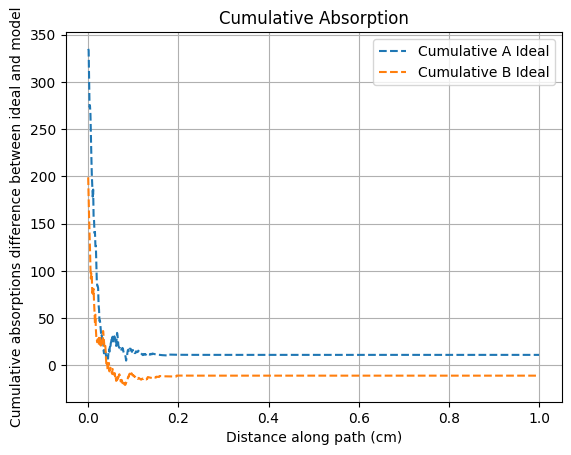

In [41]:
plt.plot(x, (A_absorbed_cumsum)-(fraction_A*num_photons*(1-transmittance_A_ideal)), label='Cumulative A Ideal', linestyle='--')
#plt.plot(x, A_absorbed_cumsum, label='Cumulative A New model')
plt.plot(x, (B_absorbed_cumsum)-(fraction_B*num_photons*(1-transmittance_B_ideal)), label='Cumulative B Ideal', linestyle='--')
#plt.plot(x, B_absorbed_cumsum, label='Cumulative B New Model')
plt.xlabel("Distance along path (cm)")
plt.ylabel("Cumulative absorptions difference between ideal and model")
plt.title("Cumulative Absorption")
plt.legend()
plt.grid(True)

/tmp/ipython-input-38-4099929253.py:48: RuntimeWarning: divide by zero encountered in log10
  absorbance = -np.log10(transmission)


0.9462371613657931
0.9596778710243448
1.0


/tmp/ipython-input-42-3315057255.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, fraction_A*(transmittance_A_ideal)/x, label='Photons absorbed by A per step in ideal case')  #This gave me something weird. issue with the scaling?


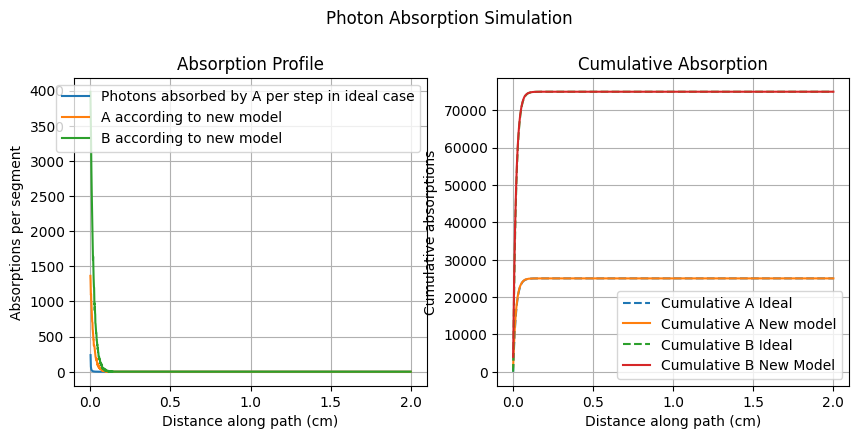

In [42]:
num_photons = 100000            # Number of photons to simulate               # Molar extinction coefficient (L·mol⁻¹·cm⁻¹)
path_length = 2
epsilon_A = 3000.0  # L/(mol*cm)
conc_A = 0.002  # mol/L
epsilon_B = 3000                            ##Situation where A has higher concentration than B
conc_B = 0.006
dx = 0.001
resolution = path_length/dx
resolution = round(resolution) #turns from a float to an int to prevent an error in the linspace function
fraction_A = conc_A*epsilon_A / (conc_A*epsilon_A + conc_B*epsilon_B)
fraction_B = conc_B*epsilon_B / (conc_A*epsilon_A + conc_B*epsilon_B)  #Fractional absorbance of A and B

# From the old model
absorbance, distances, profile_A, profile_B,transmission = Absorption_model(
    num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx
    )

cumulative_A = np.cumsum(profile_A)
cumulative_B = np.cumsum(profile_B)



#From the improved one
A_absorbed_count_per_length, B_absorbed_count_per_length, A_absorbed_cumsum, B_absorbed_cumsum = Absorption_model_Number_line(num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx)
absorbance_A_ideal, transmittance_A_ideal = lambert_beer_law(conc_A, conc_B, path_length, epsilon_A, epsilon_B, resolution)
absorbance_B_ideal, transmittance_B_ideal = lambert_beer_law(conc_A, conc_B, path_length, epsilon_A, epsilon_B, resolution)
cumulative_A_ideal = np.cumsum(absorbance_A_ideal)
cumulative_B_ideal = np.cumsum(absorbance_B_ideal)
cumulative_transmittance_A_ideal = np.cumsum(transmittance_A_ideal)
cumulative_B_transmittance_B_ideal = np.cumsum(transmittance_B_ideal)
x = np.linspace(0, path_length, len(profile_A))

# Plotting the results

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x, fraction_A*(transmittance_A_ideal)/x, label='Photons absorbed by A per step in ideal case')  #This gave me something weird. issue with the scaling?
#plt.plot(x, profile_A, label='Absorbed by A per step')
plt.plot(x, A_absorbed_count_per_length, label='A according to new model' )
#plt.plot(x, profile_B, label='Absorbed by B per step')
plt.plot(x, B_absorbed_count_per_length, label='B according to new model' )
plt.xlabel("Distance along path (cm)")
plt.ylabel("Absorptions per segment")
plt.title("Absorption Profile")
plt.legend()
plt.grid(True)

 # Plot: Cumulative absorption
plt.subplot(1, 2, 2)
#plt.plot(x, cumulative_B, label='Cumulative A')
plt.plot(x, fraction_A*num_photons*(1-transmittance_A_ideal), label='Cumulative A Ideal', linestyle='--')
plt.plot(x, A_absorbed_cumsum, label='Cumulative A New model')

#plt.plot(x, cumulative_A, label='Cumulative B')
plt.plot(x, fraction_B*num_photons*(1-transmittance_B_ideal), label='Cumulative B Ideal', linestyle='--')
plt.plot(x, B_absorbed_cumsum, label='Cumulative B New Model')
plt.xlabel("Distance along path (cm)")
plt.ylabel("Cumulative absorptions")
plt.title("Cumulative Absorption")
plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.suptitle(f"Photon Absorption Simulation", y=1.05)
plt.show()

/tmp/ipython-input-38-4099929253.py:48: RuntimeWarning: divide by zero encountered in log10
  absorbance = -np.log10(transmission)


0.9078205301781858
0.9209890258670164
1.0


/tmp/ipython-input-43-2700236347.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, fraction_A*(transmittance_A_ideal)/x, label='Photons absorbed by A per step in ideal case')  #This gave me something weird. issue with the scaling?


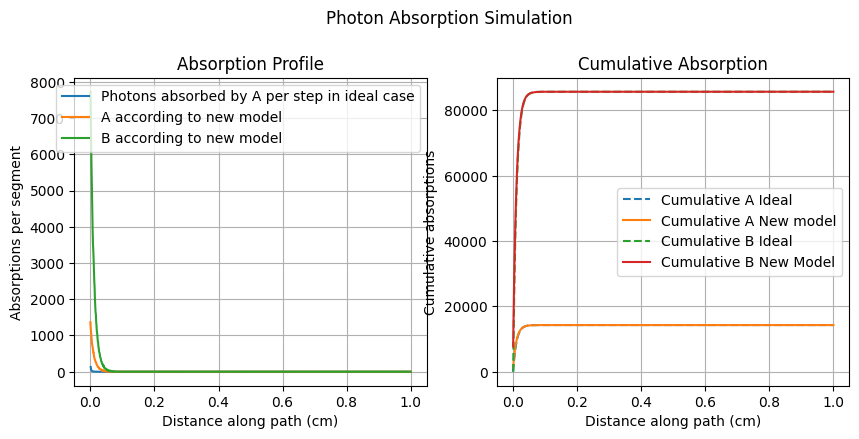

In [43]:
num_photons = 100000            # Number of photons to simulate               # Molar extinction coefficient (L·mol⁻¹·cm⁻¹)
path_length = 1
epsilon_A = 3000.0  # L/(mol*cm)
conc_A = 0.002  # mol/L
epsilon_B = 6000                            ##Situation where A has higher concentration than B
conc_B = 0.006
dx = 0.001
resolution = path_length/dx
resolution = round(resolution) #turns from a float to an int to prevent an error in the linspace function
fraction_A = conc_A*epsilon_A / (conc_A*epsilon_A + conc_B*epsilon_B)
fraction_B = conc_B*epsilon_B / (conc_A*epsilon_A + conc_B*epsilon_B)  #Fractional absorbance of A and B

# From the old model
absorbance, distances, profile_A, profile_B,transmission = Absorption_model(
    num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx
    )

cumulative_A = np.cumsum(profile_A)
cumulative_B = np.cumsum(profile_B)



#From the improved one
A_absorbed_count_per_length, B_absorbed_count_per_length, A_absorbed_cumsum, B_absorbed_cumsum = Absorption_model_Number_line(num_photons, path_length, epsilon_A, conc_A, epsilon_B, conc_B, dx)
absorbance_A_ideal, transmittance_A_ideal = lambert_beer_law(conc_A, conc_B, path_length, epsilon_A, epsilon_B, resolution)
absorbance_B_ideal, transmittance_B_ideal = lambert_beer_law(conc_A, conc_B, path_length, epsilon_A, epsilon_B, resolution)
cumulative_A_ideal = np.cumsum(absorbance_A_ideal)
cumulative_B_ideal = np.cumsum(absorbance_B_ideal)
cumulative_transmittance_A_ideal = np.cumsum(transmittance_A_ideal)
cumulative_B_transmittance_B_ideal = np.cumsum(transmittance_B_ideal)
x = np.linspace(0, path_length, len(profile_A))

# Plotting the results

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x, fraction_A*(transmittance_A_ideal)/x, label='Photons absorbed by A per step in ideal case')  #This gave me something weird. issue with the scaling?
#plt.plot(x, profile_A, label='Absorbed by A per step')
plt.plot(x, A_absorbed_count_per_length, label='A according to new model' )
#plt.plot(x, profile_B, label='Absorbed by B per step')
plt.plot(x, B_absorbed_count_per_length, label='B according to new model' )
plt.xlabel("Distance along path (cm)")
plt.ylabel("Absorptions per segment")
plt.title("Absorption Profile")
plt.legend()
plt.grid(True)

 # Plot: Cumulative absorption
plt.subplot(1, 2, 2)
#plt.plot(x, cumulative_B, label='Cumulative A')
plt.plot(x, fraction_A*num_photons*(1-transmittance_A_ideal), label='Cumulative A Ideal', linestyle='--')
plt.plot(x, A_absorbed_cumsum, label='Cumulative A New model')

#plt.plot(x, cumulative_A, label='Cumulative B')
plt.plot(x, fraction_B*num_photons*(1-transmittance_B_ideal), label='Cumulative B Ideal', linestyle='--')
plt.plot(x, B_absorbed_cumsum, label='Cumulative B New Model')
plt.xlabel("Distance along path (cm)")
plt.ylabel("Cumulative absorptions")
plt.title("Cumulative Absorption")
plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.suptitle(f"Photon Absorption Simulation", y=1.05)
plt.show()